# Street number recognition (COMP540 Spring 2017 @ Rice U)

In [170]:
import sys
import os
import numpy as np
import pandas as pd
import cPickle as pickle
# from PIL import Image
# import png
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function
from skimage.color import rgb2gray

In [2]:
home = '/Users/chih-hsulin/'

In [3]:
home = '/Users/chlin/'

# Data processing

## Load data & pre-process data

In [12]:
inputFile = home+'/data/COMP540Project2017/train.csv'
df = pd.read_csv(inputFile,sep=",")
pixels=df[df.columns[df.columns!='label']]
trainX=pixels.values.reshape(32, 32, 3, -1).transpose(3,0,1,2)
trainY=df['label'].values
inputFile = home+'/data/COMP540Project2017/test.csv'
df = pd.read_csv(inputFile,sep=",")
testX=df.values.reshape(32, 32, 3, -1).transpose(3,0,1,2)

In [13]:
inputFile = home+'/data/COMP540Project2017/extra.csv'
df = pd.read_csv(inputFile,sep=",")

In [14]:
pixels=df[df.columns[df.columns!='label']]
trainX_extra=pixels.values.reshape(32, 32, 3, -1).transpose(3,0,1,2)
trainY_extra=df['label'].values

In [55]:
def saveArray(fn,data):
    f = open(fn, 'wb')
    pickler = pickle.Pickler(f)
    data = list(data)
    for e in data:
        pickler.dump(e)
    f.close()
%timeit saveArray('mydata.pkl',trainX_extra2)

10 loops, best of 3: 60.3 ms per loop


In [57]:
def loadArray(fn):
    f = open('mydata.pkl', 'rb')
    unpickler = pickle.Unpickler(f)
    data=[]
    for i in xrange(10):
        data.append(unpickler.load())
    return(np.array(data))
%timeit trainX_extra3=loadArray('mydata.pkl')

10 loops, best of 3: 154 ms per loop


In [15]:
# Functions for saving data in bytes format
# Ref: http://stackoverflow.com/questions/37954324/how-to-load-one-line-at-a-time-from-a-pickle-file
def dumparray4D(a, path):
    lines, _,_,_ = a.shape
    with open(path, 'wb') as fd:
        for i in range(lines):
            fd.write(a[i,...].tobytes())

def dumparray1D(a, path):
    lines = a.shape[0]
    with open(path, 'wb') as fd:
        for i in range(lines):
            fd.write(a[i].tobytes())

In [16]:
# Functions for loading data in bytes format
class LineAccess4D(object):
    def __init__(self, path, col_n,row_n,depth, dtype):
        self.dtype = dtype
        self.fd = open(path, 'rb')
        self.line_length = (col_n*row_n*depth)*dtype.itemsize

    def read_line(self, line):
        offset = line*self.line_length
        self.fd.seek(offset)
        data = self.fd.read(self.line_length)
        return np.frombuffer(data, self.dtype)

    def close(self):
        self.fd.close()

class LineAccess1D(object):
    def __init__(self, path, dtype):
        self.dtype = dtype
        self.fd = open(path, 'rb')
        self.line_length = dtype.itemsize

    def read_line(self, line):
        offset = line*self.line_length
        self.fd.seek(offset)
        data = self.fd.read(self.line_length)
        return np.frombuffer(data, self.dtype)

    def close(self):
        self.fd.close()
        
def loadArrayBytes4D(path, sample_start,sample_end,col_n,row_n,depth, dtype):
    rla = LineAccess4D(path, col_n,row_n,depth, dtype)
    data = []
    for i in xrange(sample_start,sample_end):
        data.append(rla.read_line(i).reshape(col_n,row_n,depth).astype(np.float32))
    return(np.array(data))

def loadArrayBytes1D(path, sample_start,sample_end, dtype):
    rla = LineAccess1D(path, dtype)
    data = []
    for i in xrange(sample_start,sample_end):
        data+=list(rla.read_line(i).astype(np.float32))
    return(np.array(data))

In [ ]:
# dtype = trainX_extra2[0].dtype            
# dumparray(trainX_extra2,path)
# trainX_extra2.shape
# print(trainX_extra2)
# %timeit dumparray(trainX_extra2,path)

# a=trainX_extra2.astype(np.int8)
# %timeit dumparray(a,path)

In [18]:
# Subset training data
trainXs = trainX[0:5000]
trainYs = trainY[0:5000]
trainX=trainXs
trainY=trainYs

(5000, 32, 32, 3)

In [20]:
# Crop data to 28 x 28
trainX_all_crop = trainX_all[:,2:-2,2:-2]


In [22]:
trainX_all_crop.shape

(604388, 28, 28, 3)

## Save pre-processed data

In [4]:
pFile = open(home+'/data/COMP540Project2017/train.pkl', 'wb')
pickle.dump((trainX,trainY), pFile, protocol=pickle.HIGHEST_PROTOCOL)
pFile.close()

In [ ]:
pFile = open(home+'/data/COMP540Project2017/test.pkl', 'wb')
pickle.dump(testX, pFile, protocol=pickle.HIGHEST_PROTOCOL)
pFile.close()

In [5]:
pFile = open('../data/trainSubset.pkl', 'wb')
pickle.dump((trainXs,trainYs), pFile, protocol=pickle.HIGHEST_PROTOCOL)
pFile.close()

NameError: name 'trainXs' is not defined

In [11]:
# Save extra data into bytes format
path = home+'/data/COMP540Project2017/trainX_extra.bytes'
trainX_extra = trainX_extra.astype(np.uint8)
dumparray4D(trainX_extra,path)
trainY_extra = trainY_extra.astype(np.uint8)
path = home+'/data/COMP540Project2017/trainY_extra.bytes'
dumparray1D(trainY_extra,path)

KeyboardInterrupt: 

In [112]:
print(trainX_extra.shape)
print(trainY_extra.shape)

(531131, 32, 32, 3)
(531131,)


In [17]:
# Combine training and extra training data
trainX_all = np.concatenate([trainX,trainX_extra],axis=0)
print(trainX_all.shape)
trainY_all = np.concatenate([trainY,trainY_extra],axis=0)
print(trainY_all.shape)

(604388, 32, 32, 3)
(604388,)


In [18]:
# Save training and extra training data
path = home+'/data/COMP540Project2017/trainX_all.bytes'
# a=trainX_extra2.astype(np.int8)
# %timeit dumparray(a,path)
trainX_all = trainX_all.astype(np.uint8)
dumparray4D(trainX_all,path)
trainY_all = trainY_all.astype(np.uint8)
path = home+'/data/COMP540Project2017/trainY_all.bytes'
dumparray1D(trainY_all,path)

In [23]:
path = home+'/data/COMP540Project2017/trainX_all_crop.bytes'
# a=trainX_extra2.astype(np.int8)
# %timeit dumparray(a,path)
trainX_all_crop = trainX_all_crop.astype(np.uint8)
dumparray4D(trainX_all_crop,path)

## Load pre-processed data

In [4]:
# Load subset of training data
pFN = '../data/trainSubset.pkl'
pFile = open(pFN, 'rb')
trainX,trainY = pickle.load(pFile)

EOFError: 

In [24]:
pFN = home+'/data/COMP540Project2017/train.pkl'
pFile = open(pFN, 'rb')
trainX,trainY = pickle.load(pFile)
pFN = home+'/data/COMP540Project2017/test.pkl'
pFile = open(pFN, 'rb')
testX = pickle.load(pFile)

In [8]:
# Load extra data
dtype=np.dtype(np.int8)
type(dtype)
sample_end = 531131
sample_start = 0
# sample_end = 10
col_n = 32
row_n = 32
depth = 3
path = home+'/data/COMP540Project2017/trainX_extra.bytes'
trainX_extra = loadArrayBytes4D(path, sample_start,sample_end,col_n,row_n,depth, dtype)
# print(train4)
path = home+'/data/COMP540Project2017/trainY_extra.bytes'
trainY_extra = loadArrayBytes1D(path,sample_start,sample_end,dtype)

In [8]:
# Load training + extra data
dtype=np.dtype(np.int8)
type(dtype)
sample_end = 604388
sample_start = 0
# sample_end = 10
col_n = 32
row_n = 32
depth = 3
path = home+'/data/COMP540Project2017/trainX_all.bytes'
trainX_all = loadArrayBytes4D(path, sample_start,sample_end,col_n,row_n,depth, dtype)
# print(train4)
path = home+'/data/COMP540Project2017/trainY_all.bytes'
trainY_all = loadArrayBytes1D(path,sample_start,sample_end,dtype)
print(trainX_all.shape)
print(trainY_all.shape)

(604388, 32, 32, 3)
(604388,)


# Visualizing data

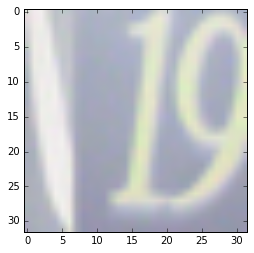

In [19]:
# Take a glance of data
plt.imshow(trainX[0])

1
9
2
3
2
5
9
3
3
1


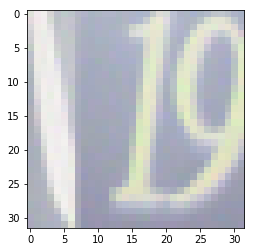

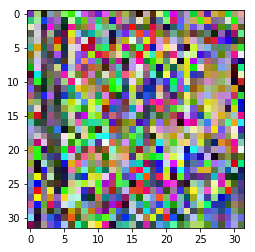

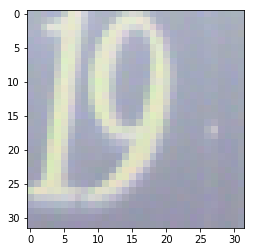

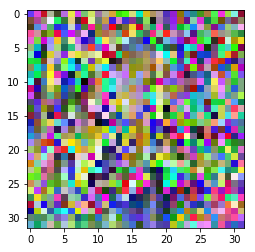

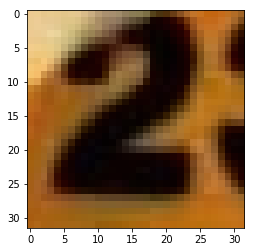

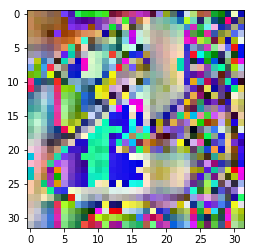

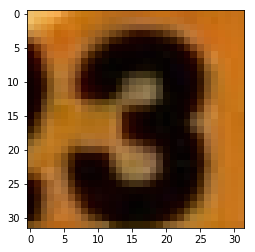

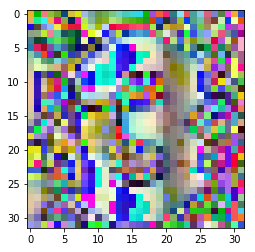

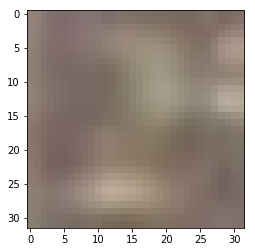

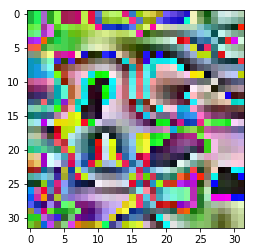

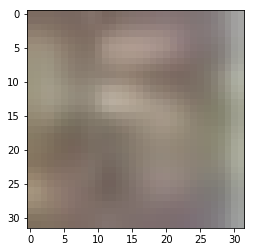

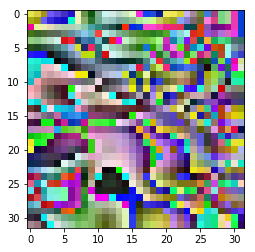

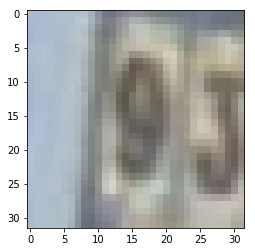

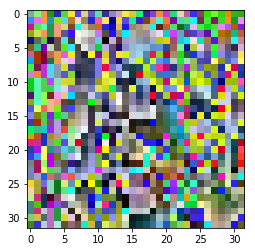

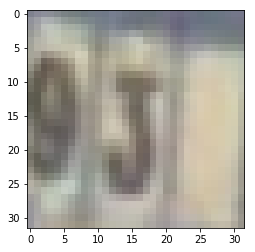

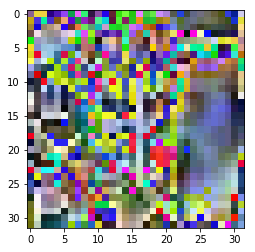

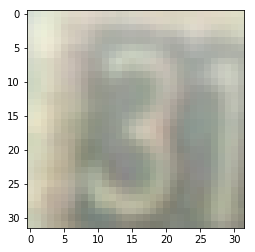

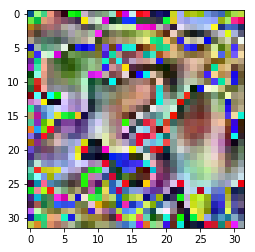

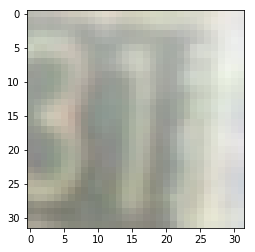

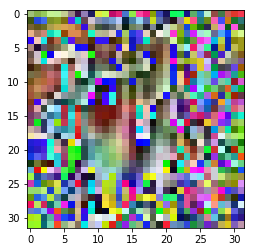

In [189]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

def stadardization1d(d):
    m = StandardScaler()
    d_norm = m.fit_transform(d)
    return(d_norm)

def stadardization3d(d):
    m = StandardScaler()
    d_norm = []
    for i in xrange(3):
        d1 = d[:,:,i].astype(np.float32)
        d2= m.fit_transform(d1)
        d_norm.append(d2)
    d_norm = np.array(d_norm)
    d_norm=d_norm.transpose(1,2,0)    
    return(d_norm)

def minMaxNorm(d):
    m = MinMaxScaler()
    d_norm = []
    for i in xrange(3):
        d1 = d[:,:,i].astype(np.float32)
        d2= m.fit_transform(d1)
        d_norm.append(d2)
    d_norm = np.array(d_norm)
    d_norm=d_norm.transpose(1,2,0)    
    return(d_norm)

def minMaxNormSample(d):
    d = d.astype(np.float32)
    minV = d[d.nonzero()].min()
    maxV = d.max()
    d_norm = (d-minV)/(maxV-minV)
    return(d_norm)

for i in xrange(10):
    plt.figure()
    print(trainY[i])
    data = trainX[i].astype(np.float32)
    plt.imshow(data)
#     plt.figure()
#     plt.imshow(minMaxNorm(trainX[i]))
    plt.figure()
#     plt.imshow(stadardization3d(trainX[i]))
#     data = rgb2gray(data/255)
#     plt.figure()
#     plt.imshow(data,cmap='gray')
#     plt.figure()
#     plt.imshow(stadardization1d(data),cmap='gray')    
#     plt.figure()
#     plt.imshow(-data,cmap='gray')
#     plt.figure()
#     plt.imshow(stadardization1d(-data),cmap='gray')    



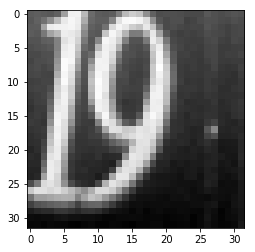

In [228]:
data = trainX[0:2].astype(np.float32)
data1 = rgb2gray(data/255)
data2 = -rgb2gray(data/255)
# data2 = data2+data2.min()
data2 = minMaxNormSample(data2)
data1 = minMaxNormSample(data1)
# data = np.concatenate([data1,data2],axis=0)
plt.imshow(data2[1],cmap="gray")
# print(data1)
# print(data2)

In [206]:
data.shape[1:]

(32, 32)

In [97]:
print(trainX[0].shape)

(32, 32, 3)


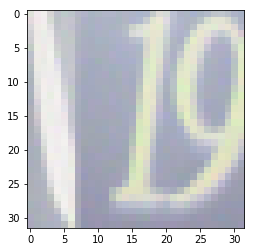

In [125]:
d = trainX[0].astype(np.float32)
plt.imshow(d)

12.0 114.0


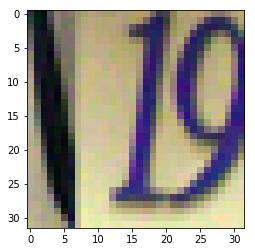

In [126]:
minV = d[d.nonzero()].min()
maxV = d.max()
d2 = (d-minV)/(maxV-minV)
# d = trainX[0][:,:,0].astype(np.float32)
plt.imshow(d2)
print(minV,maxV)

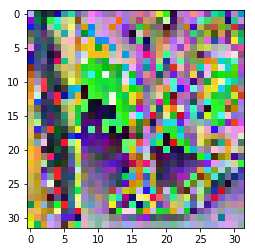

In [116]:
avg = d.mean()
std = d.std()
d3 = (d-avg)/std
plt.imshow(d3)

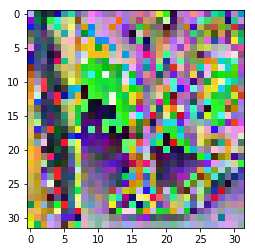

In [117]:
avg = d2.mean()
std = d2.std()
d4 = (d2-avg)/std
plt.imshow(d4)

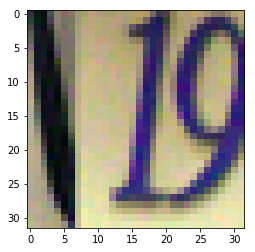

In [118]:
minV = d3.min()
maxV = d3.max()
d5 = (d3-minV)/(maxV-minV)
plt.imshow(d5)

# Feature extraction

## Extract patches

In [26]:
from sklearn.feature_extraction import image

def extractPatches(X, patchSize = (3,3)):
    trainX_patches = []
    for x in trainX:
        patches = image.extract_patches_2d(x, patchSize)
    #     print patches.shape
        patches=patches.reshape(len(patches), -1)
        data = np.reshape(patches, (len(patches), -1))
    #     print data.shape
        data = np.concatenate(data, axis=0)
    #     print data.shape
        trainX_patches.append(data)
    return np.array(trainX_patches)

# d = np.concatenate(trainXs_patches, axis=0)
# d.shape
trainX_patches = extractPatches(trainX)
trainX_patches.shape

(5000, 24300)

# Feature normalization

In [36]:
from sklearn import preprocessing

def scaling(X):
    return preprocessing.scale(X)
trainX_scaled = scaling(trainX_patches)
# trainX_scaled = trainX_patches
trainX_scaled[0][0:10]

array([-1.58759226, -1.59543497, -1.50958898, -1.93837705, -1.73761541,
       -1.88353038, -1.93840333, -1.85714094, -1.89809678, -1.69058637])

# Feature selection

In [37]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

def selectVariedFeatures(X):
    sel = VarianceThreshold(threshold=0.1)
    return sel.fit_transform(X)

def selectFeatures_tree(X,y):
    clf = ExtraTreesClassifier()
    clf = clf.fit(X, y)
    model = SelectFromModel(clf, prefit=True)
    X_new = model.transform(X)
    return X_new

trainX_scaled_selected = selectFeatures_tree(trainX_scaled,trainY)
print '{} features were selected down to {} features'.format(trainX_scaled.shape[1],trainX_scaled_selected.shape[1])
print trainX_scaled_selected.shape
print trainY.shape

# trainX_scaled_selected = selectVariedFeatures(trainX_scaled)
# print '{} features were selected down to {} features'.format(trainX_scaled.shape[1],trainX_scaled_selected.shape[1])
# print trainX_scaled_selected.shape
# print trainY.shape


24300 features were selected down to 9355 features
(5000, 9355)
(5000,)


# Dimensionality reduction

In [49]:
from sklearn.decomposition import IncrementalPCA,PCA
def PCAdecomposition(X,n=3):
#     ipca = IncrementalPCA(n_components=n)
    pca = PCA(n_components=n)
    pca.fit(X)
    newX = pca.transform(X)
    print 'Explained variance %: {}'.format(pca.explained_variance_ratio_)
    return newX
trainX_scaled_selected = PCAdecomposition(trainX_scaled_selected)
print trainX_scaled_selected.shape

Explained variance %: [ 0.85579893  0.08584543  0.05835564]
(5000, 3)


# Models

In [50]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

## OVA

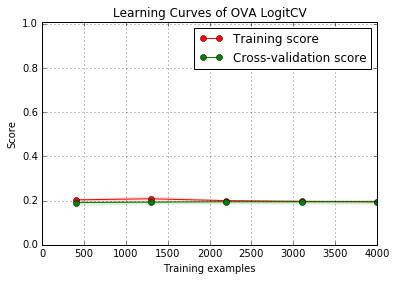

In [51]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegressionCV


cv = KFold(n_splits=5, random_state=0)
title = "Learning Curves of OVA LogitCV"
estimator = OneVsRestClassifier(LogisticRegressionCV(random_state=0))
x=plot_learning_curve(estimator, title, trainX_scaled_selected, trainY, ylim=(0, 1.01), cv=cv, n_jobs=4)
x.show()

# model = OneVsRestClassifier(LogisticRegressionCV(random_state=0)).fit(trainX_scaled_selected, trainY)
# print model.predict(trainX_scaled_selected)
# print trainY